In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import PIL.Image as Imag 
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader

In [2]:
import os

desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
print(desktop_path)
dataset_total = pd.read_csv("C:/Users/PC/Desktop/retinopathy_data/data/labels/label.csv")
train_test_image_directory = "C:/Users/PC/Desktop/retinopathy_data/data/test_train_images"
validation_directiory = "C:/Users/PC/Desktop/retinopathy_data/data/validation_images"

C:\Users\PC\Desktop


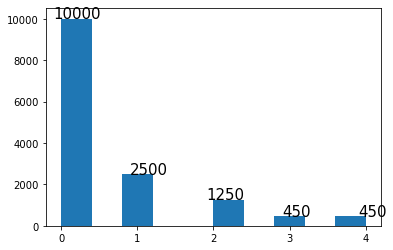

In [27]:
dataset_total[dataset_total["validation"] == 1].level.hist()

plt.xticks([0,1,2,3,4])
plt.grid(False)

# Get the value counts of each class
value_counts = dataset_total[dataset_total["validation"] == 1].level.value_counts()

# Add the value counts as text to the graph
for i, count in enumerate(value_counts):
    plt.text(i-0.1, count+20, str(count), fontsize=15)

plt.show()

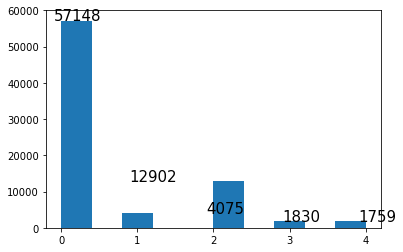

In [28]:
dataset_total[dataset_total["validation"] == 0].level.hist()

plt.xticks([0,1,2,3,4])
plt.grid(False)

# Get the value counts of each class
value_counts = dataset_total[dataset_total["validation"] == 0].level.value_counts()

# Add the value counts as text to the graph
for i, count in enumerate(value_counts):
    plt.text(i-0.1, count+20, str(count), fontsize=15)

plt.show()

In [34]:
def extract_bv(image):
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)

    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)	
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)

    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255	
    contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=mask)
    ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)	
    xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"	
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
    blood_vessels = cv2.bitwise_not(finimage)
    return blood_vessels

#FOR TAGGING
def blurry_or_not(laplacian_value):
    
    if laplacian_value <10000:
        return 0
    else:
        return 1
  
    

In [39]:
def preprocess_image(image):
    # Ensure image is color image with 3 channels

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
    l_normalized = clahe.apply(l)
    normalized_lab = cv2.merge((l_normalized, a, b))
    normalized_bgr = cv2.cvtColor(normalized_lab, cv2.COLOR_LAB2BGR)

    return normalized_bgr

In [31]:
import random
def show_images_by_level(filter=None):
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
    axs = axs.flatten()

    images_by_level = {level: [] for level in range(5)}
    for i in range(2000):
        i = random.randint(0,1000)
        
        level = dataset_total["level"][i]
        image_path = f'{train_test_image_directory }/{dataset_total["image"][i]}.jpg'
        image = cv2.imread(image_path)
        image = cv2.resize(image,(512,512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if filter is not None:
            for j in range(len(filter)):
                image = filter[j](image)
        images_by_level[level].append(image)

    for i, level in enumerate(range(5)):
        images = images_by_level[level][:5]
        for j in range(len(images)):

            axs[5 * j + i].imshow((images[j]))
            axs[5 * j + i].set_title(f'Level: {level}')
            axs[5 * j + i].axis('off')
            # Add label to the bottom of the image
            axs[5 * j + i].text(0.5, -0.1, (cv2.Laplacian(extract_bv(images[j]), cv2.CV_64F).var()), transform=axs[5 * j + i].transAxes,
                                 fontsize=12, ha='center', va='bottom')
            
    plt.tight_layout()
    plt.show()

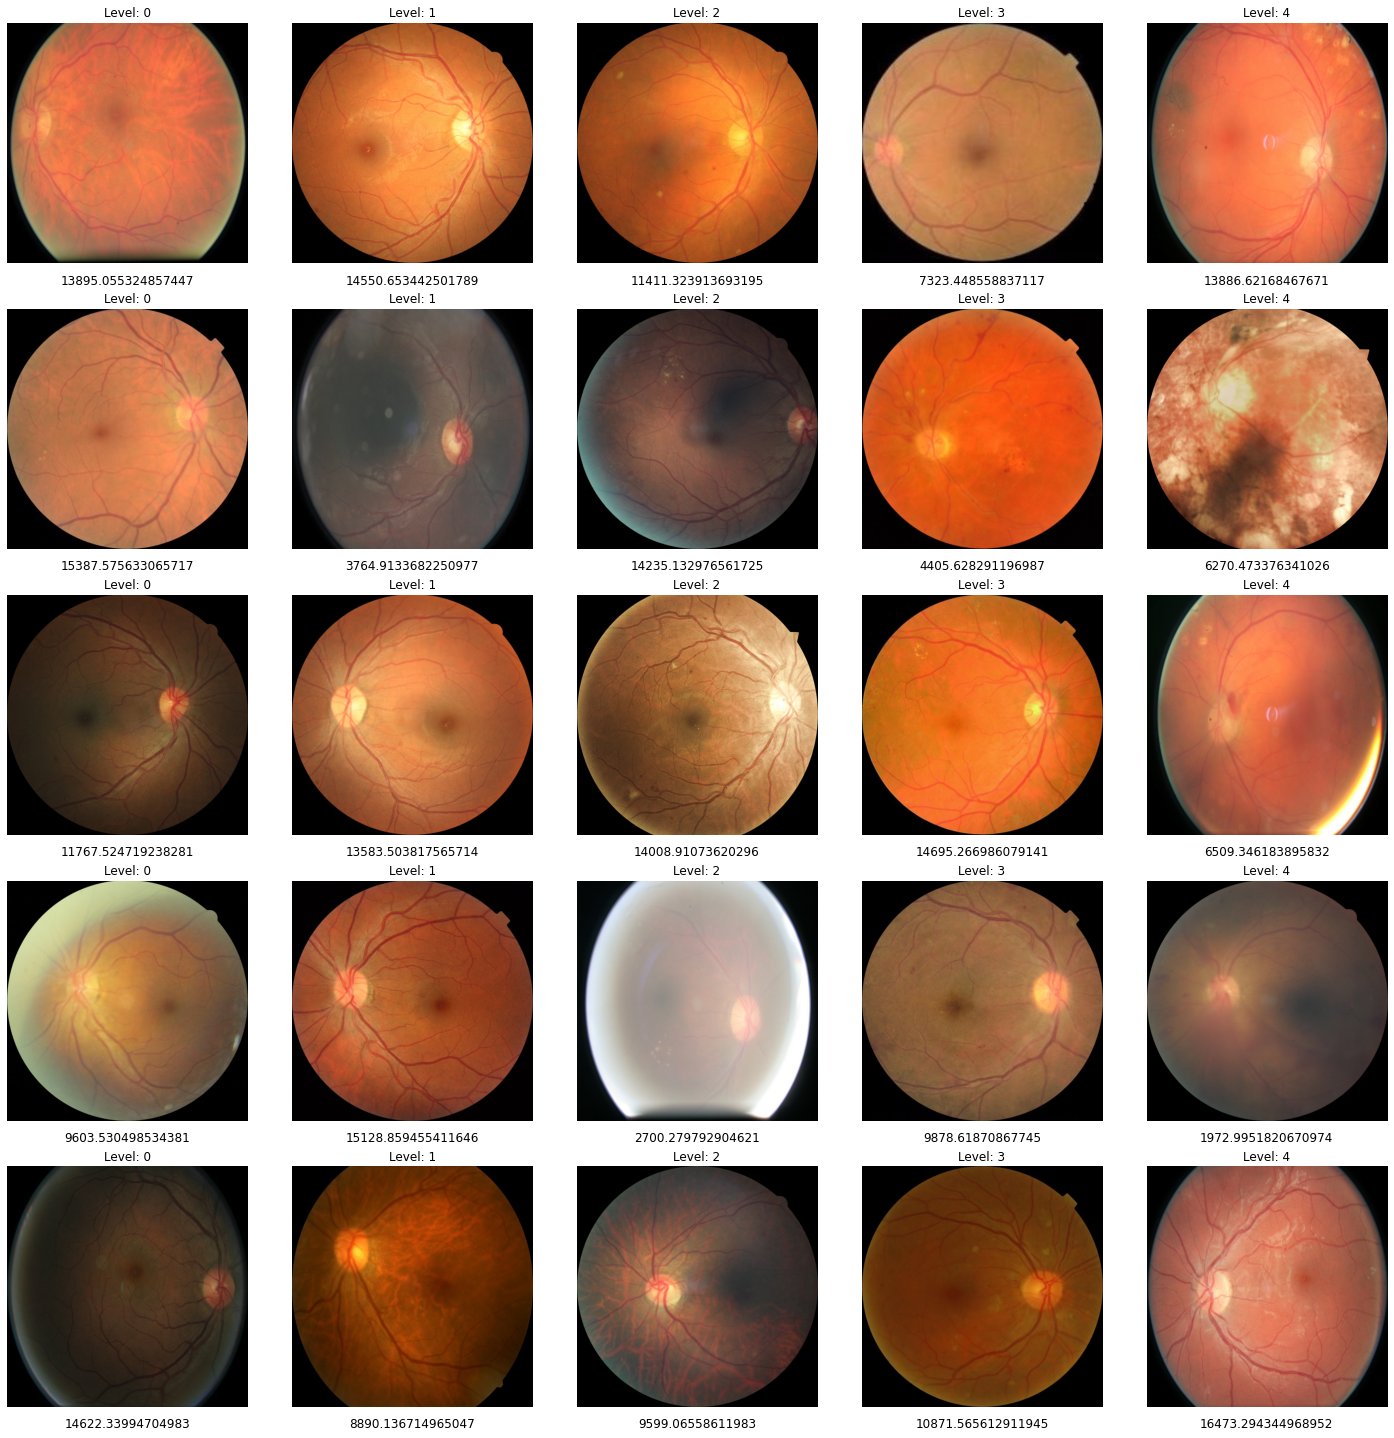

In [35]:
show_images_by_level(filter =[])

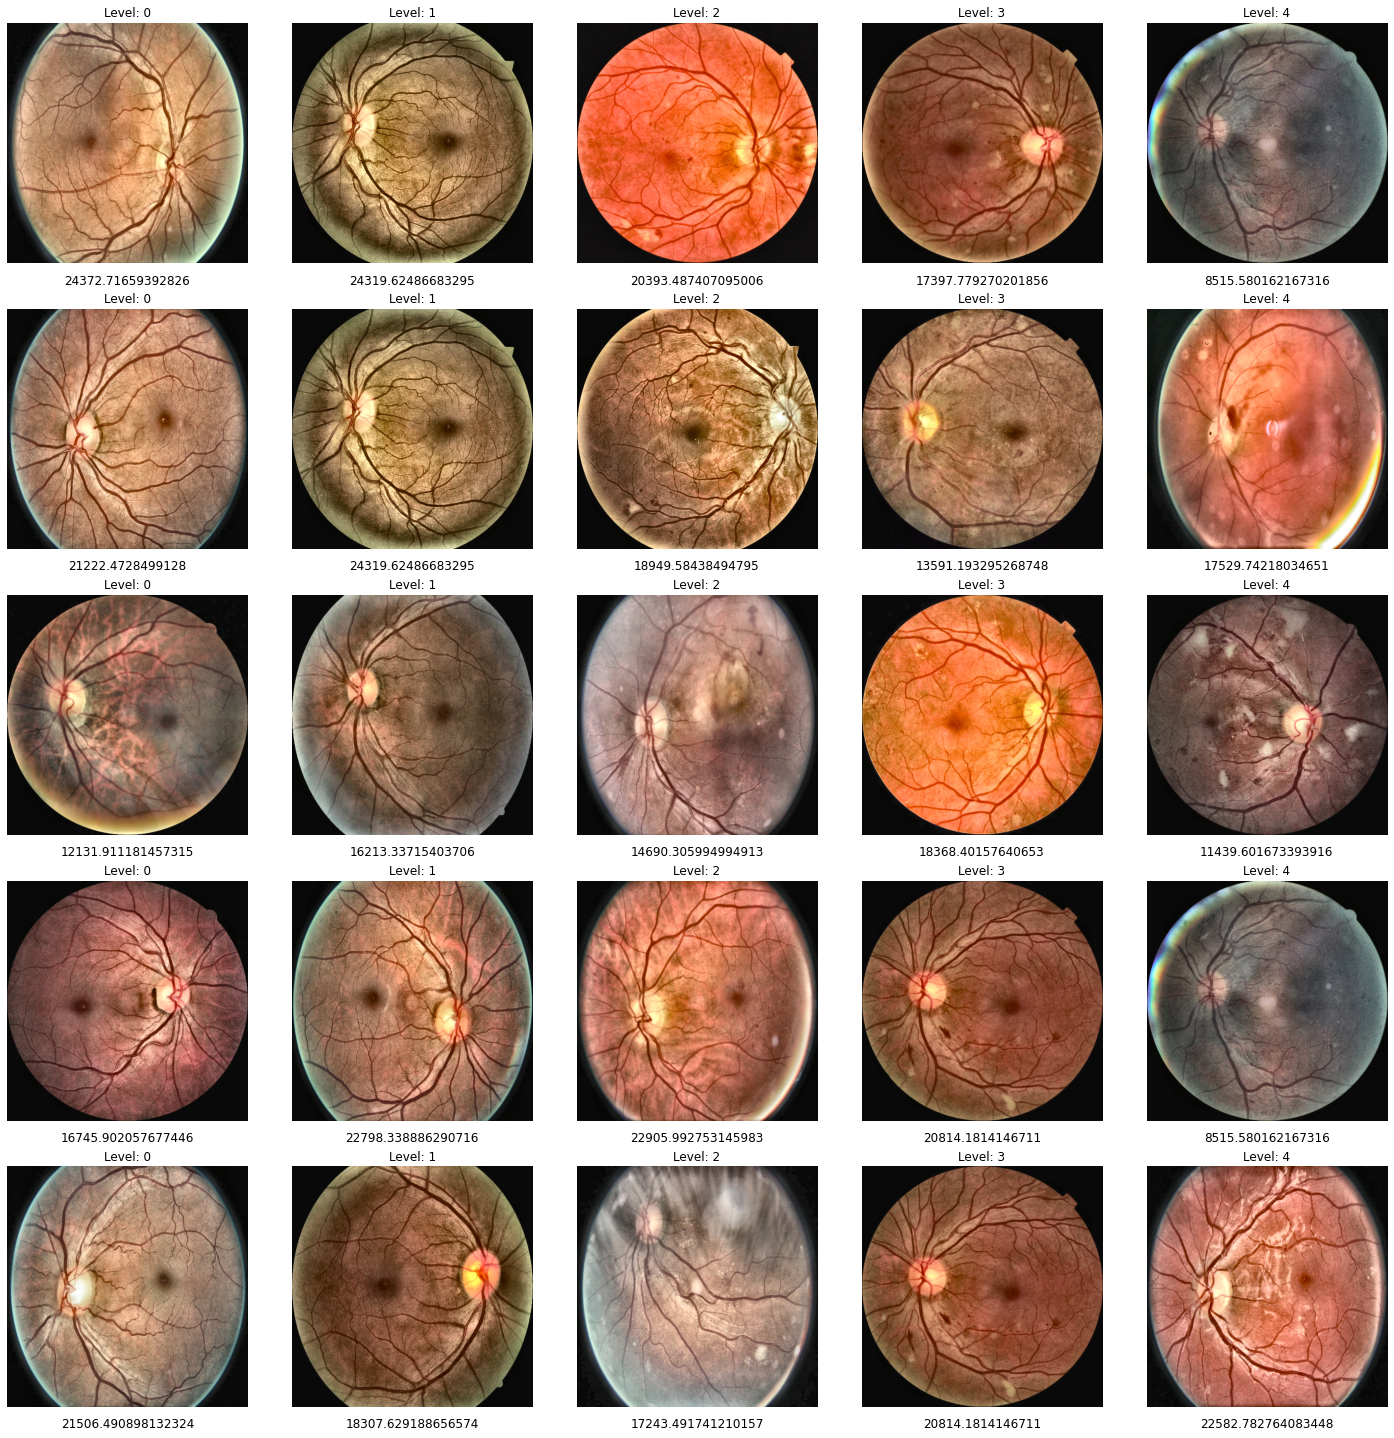

In [40]:
show_images_by_level(filter =[preprocess_image])